In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import jax.numpy as jnp

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [10]:
width = 3.65
height = 1.0  #1.109  #0.829
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
titlesize = 8
spotsize = 6**2
xticks = [2, 4, 6, 8]

plt.rcParams.update({
    'figure.figsize': figsize,
    'figure.dpi': 300,
    'font.size': labelsize,
    'axes.labelsize': labelsize,
    'xtick.labelsize': ticklabelsize,
    'ytick.labelsize': ticklabelsize,
    'xtick.major.size': 1.5,
    'ytick.major.size': 1.5,
    'xtick.major.width': 0.6,
    'ytick.major.width': 0.6,
    'legend.fontsize': labelsize,
    'axes.titlesize': titlesize,
#     'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
})

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.275
mar_r = 0.04
mar_t = 0.14
mar_b = 0.27 + (height-0.829)  # 0.27

In [11]:
def format_figure(fig, axs):
    fig.set_size_inches(figsize)

    plt.setp(
        axs,
        ylim=[-1.1, 1.1],
        xticks=xticks,
        xlim=[1, 9],
        xlabel="",
        xticklabels="",
        # title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1.5, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        if i > 0:
            ax.yaxis.set_tick_params(length=0)
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)
        
    axs[0].set_ylabel('FAM-HEX')

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
    )

Saving fig_S8A__tangible_urchin in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


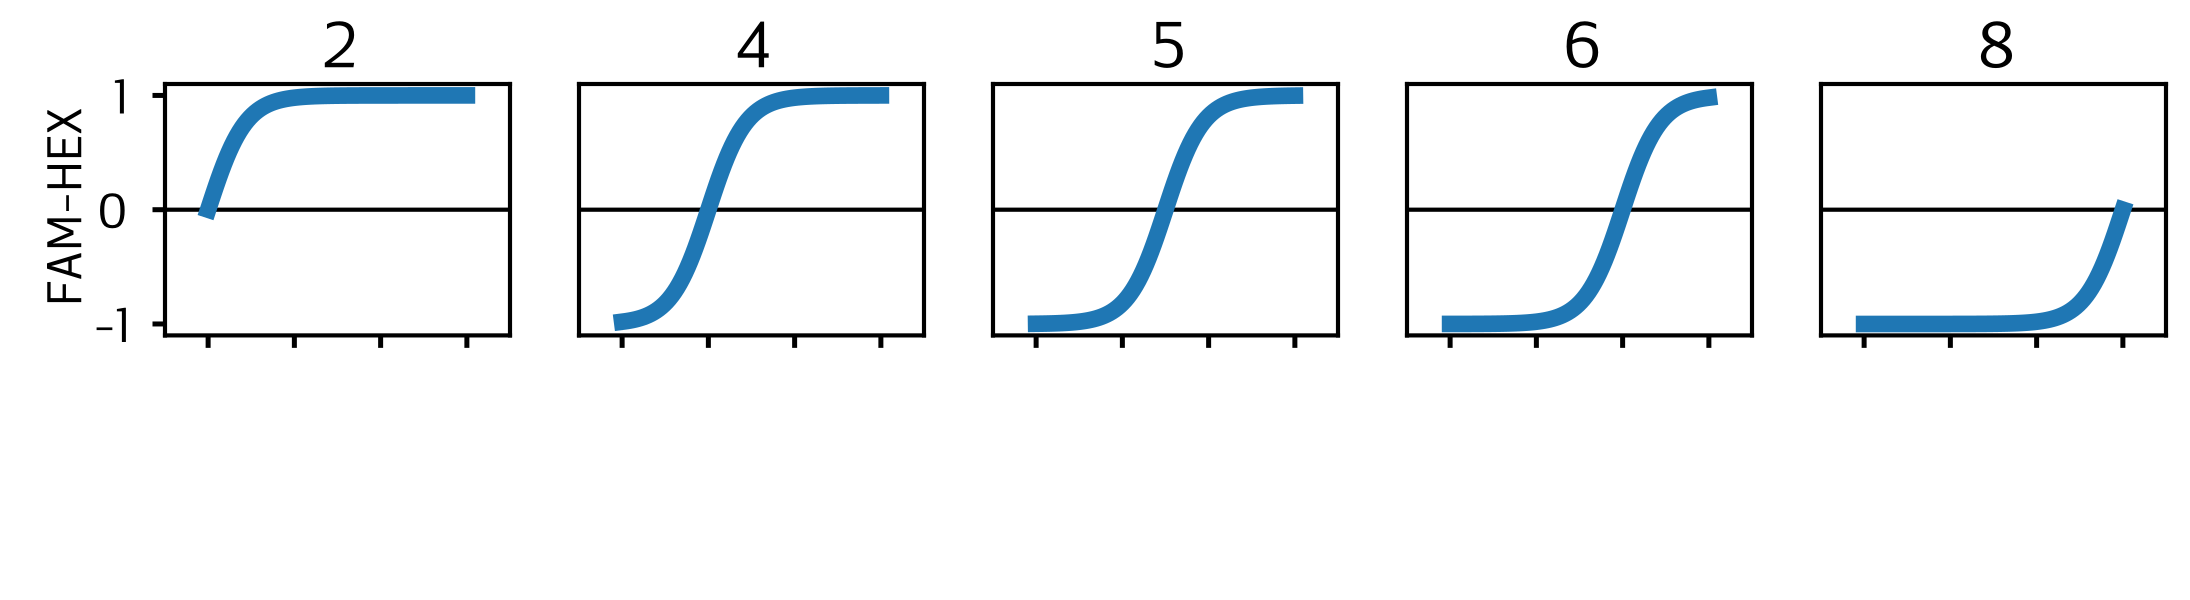

In [12]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn_b = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn_b.n_cycles = 50
rxn_b.compile()

rxn_b.norm.nM = 100

def sym_bipartite(
    ref_rate,
    ref_lgQ,
    wt_rate=0.9,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref_drift=0,
    wt_drift=0,
):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate

    rxn_b.oligo("WT").drift = wt_drift
    rxn_b.oligo("REF").drift = ref_drift

    rxn_b.oligo("REF").copies = 10**ref_lgQ

    wt_lgQ = np.linspace(wt_start, wt_end, n_points)

    arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_b.sweep_setup = arrays, grids, pts, rxn_b.INT_idxs
    sol = rxn_b.solution_sweep()
    return wt_lgQ, sol


fig, axs = plt.subplots(1, 5, figsize=figsize, sharex=True, sharey=True)

ref_rate = 0.9

for ax, ref_lgQ in zip(axs, [2, 4, 5, 6, 8]):
    wt_lgQ, sol = sym_bipartite(ref_rate=ref_rate, ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, sol, lw=2)
    ax.set_title(ref_lgQ, fontsize=titlesize, pad=2)

# plt.suptitle("Competitor Concentration (log10 copies)", fontsize=labelsize + 4, y=1.0)

format_figure(fig, axs)
# plt.tight_layout()
savefig(plt.gcf(), "tangible_urchin")

Saving fig_S8B__invisible_parrot in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


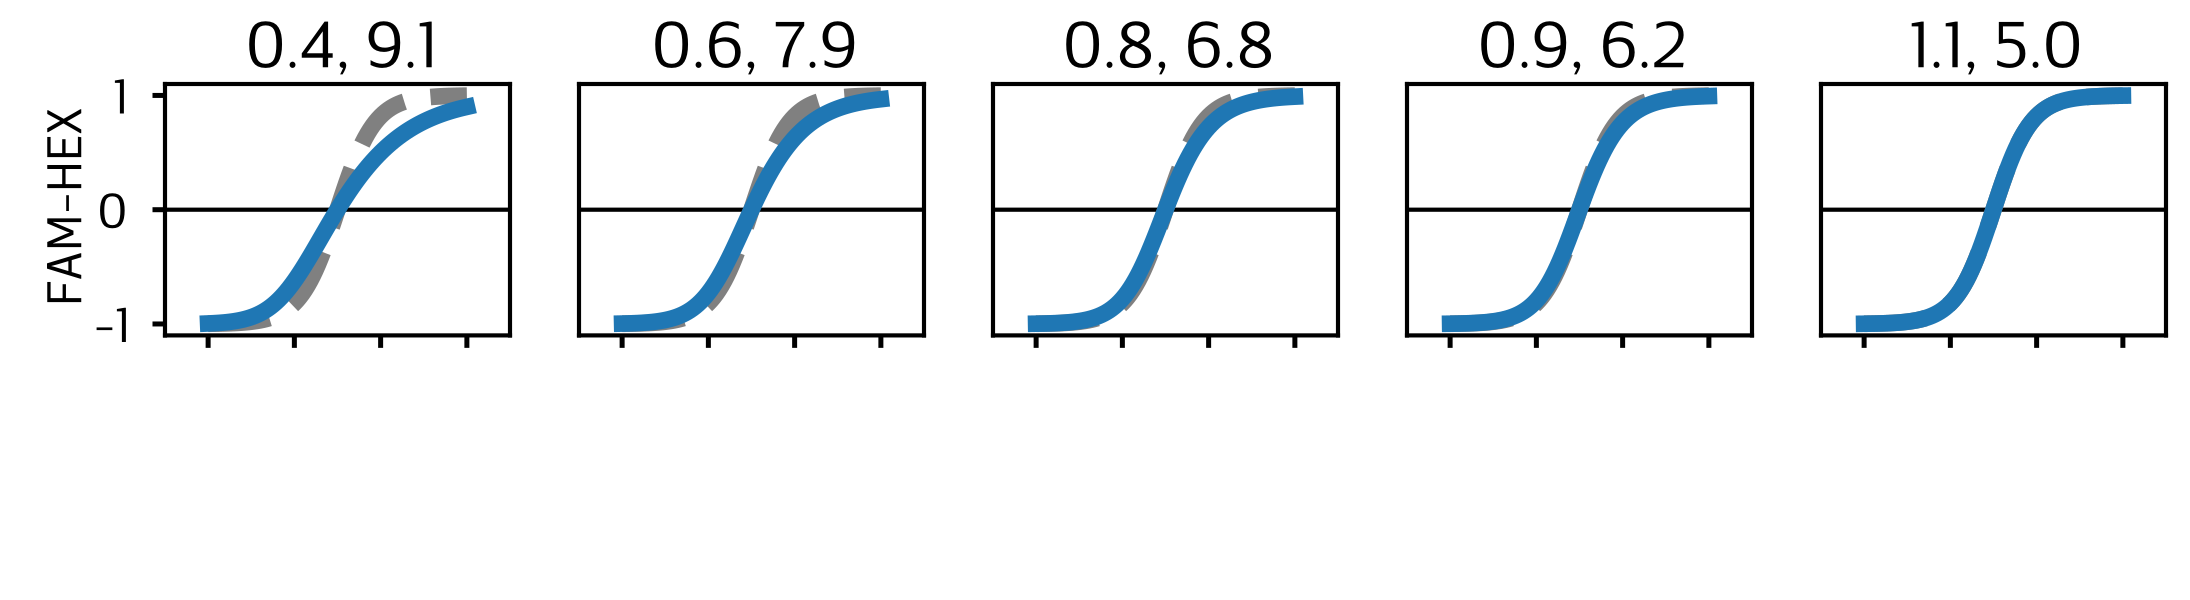

In [13]:

fig, axs = plt.subplots(1, 5, figsize=figsize, sharex=True, sharey=True)

ref_lg = 5.0
rxn_b.norm.nM = 100

def ref_lgQ_loss(ref_lgQ, ref_rate=0.9, wt_rate=1.1, wt_lgQ=5.0):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate
    rxn_b.oligo("WT").drift = 0
    rxn_b.oligo("REF").drift = 0
    rxn_b.oligo("REF").copies = 10**ref_lgQ
    rxn_b.oligo("WT").copies = 10**wt_lgQ

    rxn_b.setup_solution_sweep(rng=[wt_lgQ, wt_lgQ], res=1)
    rxn_b.sweep_setup
    loss = np.array(rxn_b.solution_sweep())[0] ** 2

    return loss

from scipy.optimize import minimize_scalar

_, mid_sol = wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=1.1, ref_lgQ=5.0)
for ax, rate, ref_lgQ in zip(axs, [0.4, 0.6, 0.8, 0.9, 1.1], [6.5, 6.0, 5, 4, 3]):
    ref_lgQ = minimize_scalar(
        ref_lgQ_loss, args=(rate, 1.1), bounds=(-1, 11), method="bounded"
    ).x
    wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=rate, ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, mid_sol, ls="--", color="gray", lw=2)
    ax.plot(wt_lgQ, sol, lw=2)
    ax.set_title(f"{rate}, {ref_lgQ:.1f}", fontsize=titlesize, pad=2)
    

format_figure(fig, axs)
savefig(plt.gcf(), "invisible_parrot")

Saving fig_S8C__oblong_quetzal in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


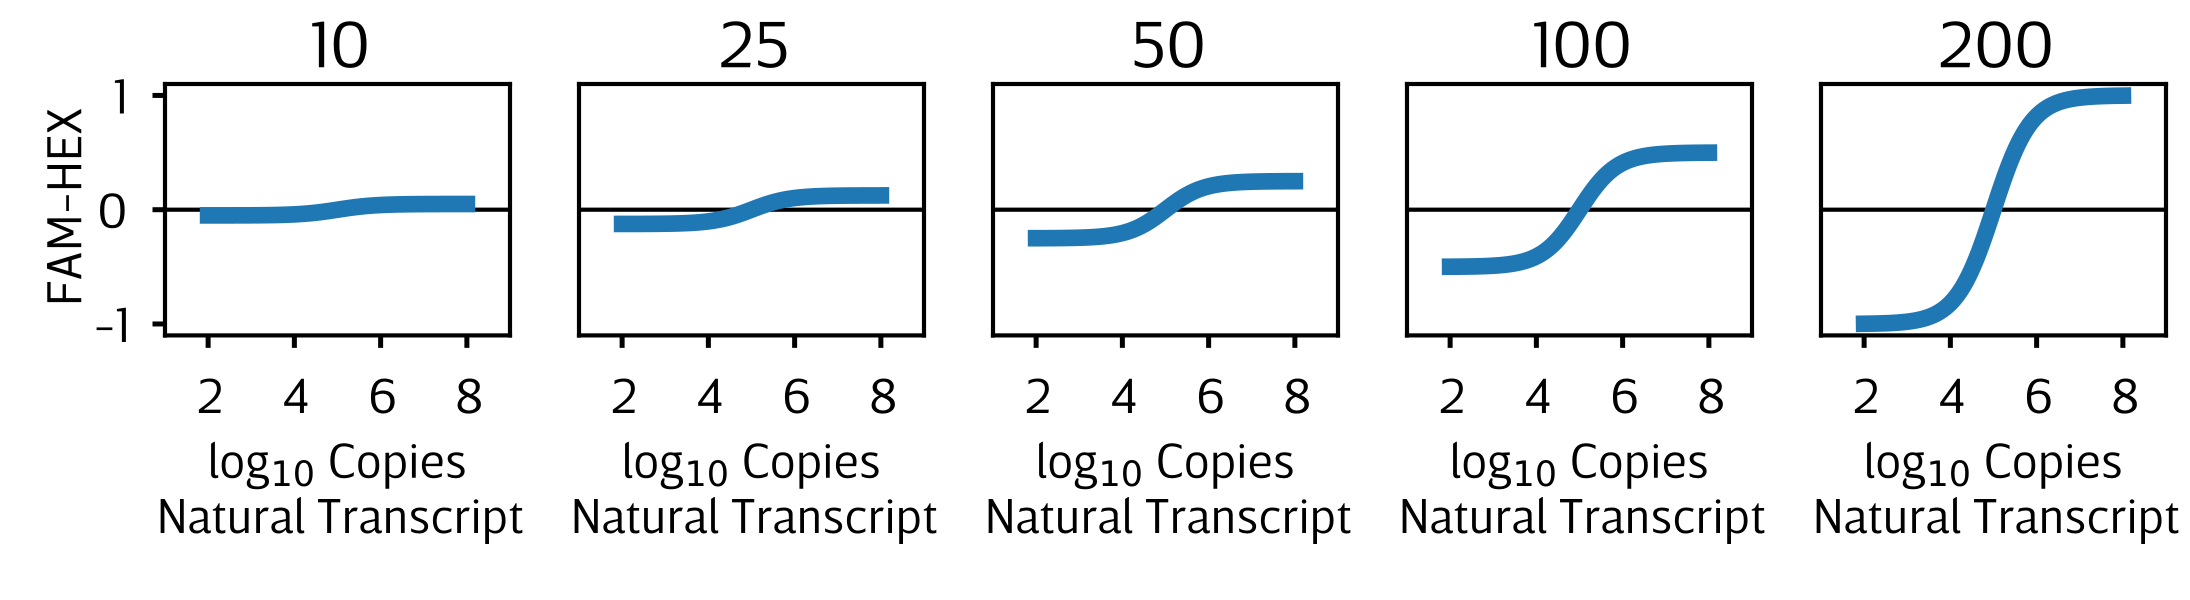

In [15]:
fig, axs = plt.subplots(1, 5, figsize=figsize, sharex=True, sharey=True)
format_figure(fig, axs)
ref_lgQ = 5.0
ref_rate = 0.8
wt_rate = 0.8

for ax, nM in zip(axs, [10, 25, 50, 100, 200]):
    rxn_b.primer_nMs = [nM, nM]
    wt_lgQ, sol = sym_bipartite(
        wt_rate=wt_rate, ref_rate=ref_rate, ref_lgQ=ref_lgQ,
    )
    ax.plot(wt_lgQ, sol/2, lw=2)
    ax.set_title(nM, fontsize=titlesize, pad=2)
    # ax.set_xlim(1, 9)
    # ax.set_ylim(-1.1, 1.1)
    # ax.set_xticks([2, 4, 6, 8])
    # ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript", fontsize=labelsize, labelpad=2)

    
# plt.tight_layout()

plt.setp(axs, xticklabels=xticks)
for ax in axs:
    ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript")
    
savefig(plt.gcf(), "oblong_quetzal")